# Preprocess Data for Schubert Winterreise Dataset

This notebook shows exemplarily how to compute input representations (HCQT) and pitch-class annotations for deep chroma estimation, at the example of the Schubert Winterreise Dataset (SWD).

&copy; Johannes Zeitler (johannes.zeitler@fau.de) and Christof Weiß (christof.weiss@audiolabs-erlangen.de), 2020/21

In [1]:
%load_ext autoreload
import numpy as np
import librosa
import librosa.display
import os
from harmonicCQT import HCQT, getHopSize
import LibFMP.B
import LibFMP.C1
import LibFMP.C3
import pandas
import matplotlib.pyplot as plt
from utils import score_to_matrices, validate_alignments, checkFrameShift, sonifyStereo
import IPython.display as ipd

### 1. Specify parameters and paths

In [2]:
# Audio frame rate
fs = 22050
# Desired frame rate of Constant-Q Transform (CQT), actual CQT frame rate is approx. 57Hz due to power-of-two-constraints
cqt_frameRate = 50

# CQT config
bottomNote = 'C1'
bottomPitch = librosa.note_to_midi(bottomNote)
numOctaves = 6
numHarmonics = 5
binsPerKey = 3
hopSizeCQT = getHopSize(fs, cqt_frameRate, numOctaves, numHarmonics)
print('CQT hop Size: %i; CQT frame Rate: %.3f Hz'%(hopSizeCQT, fs/hopSizeCQT))

# where the audio is stored
audioPath_source = os.path.join('Data', 'Schubert_Winterreise', 'audio_wav')

# where the pitch labels are stored
pitchPath_source = os.path.join('Data', 'Schubert_Winterreise', 'ann_audio_pitch_CSV')

# target directories for hcqt, pitch and chroma labels
hcqtPath_dest = os.path.join('Data', 'Schubert_Winterreise', 'HCQT')
pitchPath_dest = os.path.join('Data', 'Schubert_Winterreise', 'Pitch')
chromaPath_dest = os.path.join('Data', 'Schubert_Winterreise', 'Chroma')

CQT hop Size: 384; CQT frame Rate: 57.422 Hz


### 2. Read and process audio files

In [3]:
# all audio files that we want to process
fileNames = [f[:-4] for f in os.listdir(audioPath_source)]

for f in fileNames:
    
    print('processing',f)
    # load and resample audio
    audioIn, _ = librosa.load(os.path.join(audioPath_source, f+'.wav'), sr=fs)
    
    # compute HCQT in an efficient way, correct tuning deviation
    hcqt, hopSizeCQT, timeSteps = HCQT(x=audioIn, fs=fs, frameRate=cqt_frameRate, f_min=bottomNote, binsPerKey=binsPerKey, 
                            numOctaves=numOctaves, numHarmonics=numHarmonics, centerNoteToBins=True, correctTuning=True)
    
    # read the pitch labels from a csv file
    pitch = pandas.read_csv(os.path.join(pitchPath_source, f+'.csv')).to_numpy()
    
    # create pitch and chroma activation matrices at hcqt frame rate
    pitchMatrix, chromaMatrix = score_to_matrices(pitch, timeSteps, bottomPitch=bottomPitch,
                                      topPitch=bottomPitch+(numOctaves*12)-1)
    
    # save hcqt, pitch and chroma activations
    np.save(os.path.join(hcqtPath_dest, f), hcqt)
    np.save(os.path.join(pitchPath_dest, f), pitchMatrix)
    np.save(os.path.join(chromaPath_dest, f), chromaMatrix)

processing Schubert_D911-02_HU33
processing Schubert_D911-02_SC06
processing Schubert_D911-23_HU33
processing Schubert_D911-23_SC06


### 3. Validate the processing pipeline

#### 3.1 Overlay Plot
Show an overlay plot of CQT and pitch annotations

File:  Schubert_D911-23_SC06


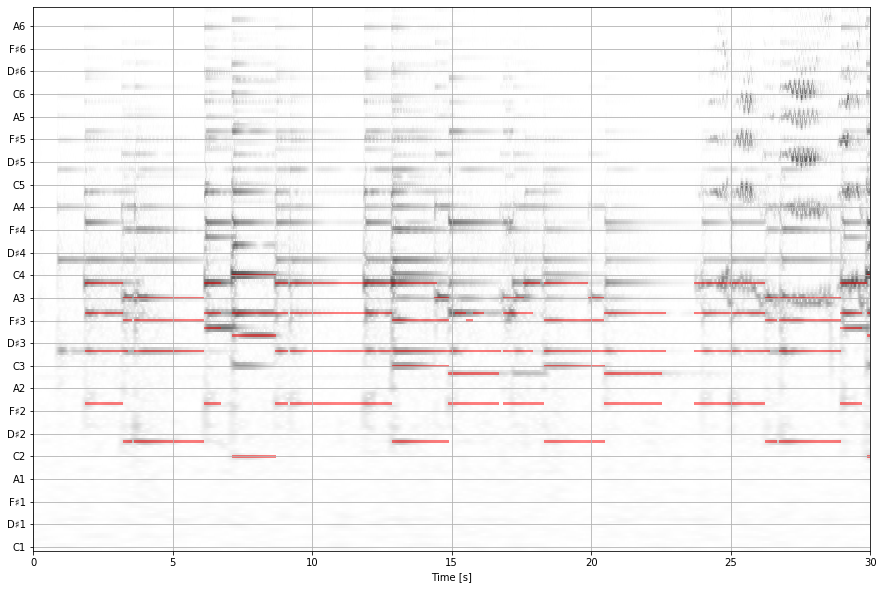

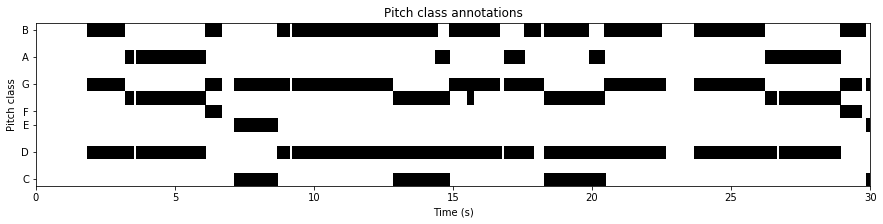

In [4]:
f = 'Schubert_D911-23_SC06'

print('File: ',f)
hcqt = np.load(os.path.join(hcqtPath_dest, f+'.npy'))
pitch = np.load(os.path.join(pitchPath_dest, f+'.npy'))
chroma = np.load(os.path.join(chromaPath_dest, f+'.npy'))

validate_alignments(cqt=hcqt[:,:,0], pitch=pitch, hopLength=hopSizeCQT, bottomNote='C1', 
                    fs=fs, binsPerKey=binsPerKey, centerNoteToBins=True, compress=10, 
                    limTime=[0,30], limPitch=None)

plt.figure(figsize=(14.95, 3))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='s', sr=fs, hop_length=hopSizeCQT, cmap='gray_r')
plt.xlim([0, 30])
plt.title('Pitch class annotations')
plt.show()

#### 3.2 Sonification
Sonify the processed data as a stereo file (Left channel: original audio, Right channel: pitch annotations sonified with sinusoidals).

In [5]:
audioIn, _ = librosa.load(os.path.join(audioPath_source, f+'.wav'), sr=fs)
son = sonifyStereo(pitch, audioIn, hopSizeCQT, fs, bottomPitch, limTime=[0,30])

son[0, :] *= 0.3
son[1, :] *= 1

ipd.display(ipd.Audio(data=son, rate=fs))